In [52]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u
import nana
from scipy.interpolate import CubicSpline

In [51]:
def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)




In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [41]:
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) 
sampling_time= np.median(np.diff(lc.time.value))
print(total_observation_time,sampling_rate)


1470.4622572100852 0.02043360086827306


In [67]:
f_max = (2 / (sampling_time))
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

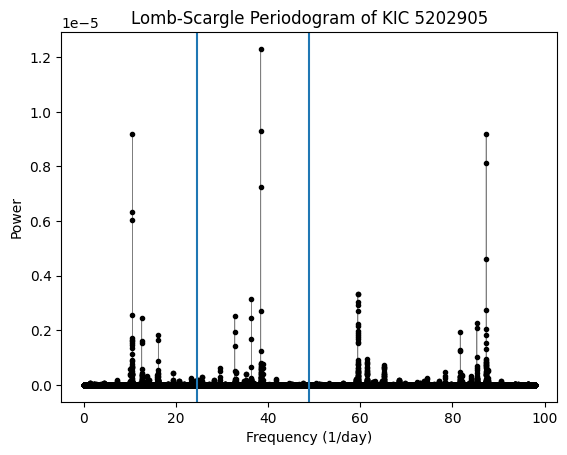

In [68]:
pg = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

plt.plot(freq, power,'k.')
plt.plot(freq, power,'k-', lw = 0.5, alpha = 0.5)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.axvline(1/sampling_time)
plt.axvline(1/(2*sampling_time))
plt.show() 
#relabel axis until they interpolate onto the same thing?
#reverse labels around same point

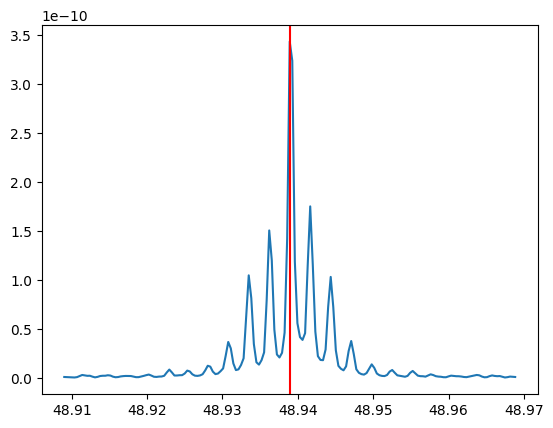

In [69]:
#relabel axis until they interpolate onto the same thing
#reverse labels around same point
#each point has freq and power
#find new set of freuqencys gi = f1-fi (magical number) 
#tune it until it maximizes the dot product 
#spline???
#btw mess up the ordering 
#dumb thing to do:
    #we have a set of powers and two coordiantes fi and gi related by equation above
cs = CubicSpline(freq, power, extrapolate=False)
tiny, small = 0.5 * delta_f, 0.03
f1s = np.arange(1/sampling_time - small, 1/sampling_time+small, tiny)
foos = np.array([np.nansum(power * cs(f1 + freq)) for f1 in f1s])
plt.plot(f1s, foos)
plt.axvline(1 / sampling_time, color="red")
#four separate periodogram at rough breakpoints and learn the transformation between the four
#figure our which flip take A to B
#what shift gets you to A to C
#what flip gets you do A to D around f1 (label threse freqs fb, fc, fd)
#always start from A
#find freqs and plot

In [7]:
indices = get_started(20, freq, power)
refined_freq, refined_power, second_derivatives = refine_peaks(freq,power, indices)

In [8]:
print(refined_freq, refined_power)

[ 38.39793161  10.54113514  87.33700543 136.27612239  59.48022385
  59.48271053  36.37205006 136.27327446 108.42442646 136.27860647
  59.47742049 185.22029981 185.2123883  108.41650755 157.36611748
  10.54362997  32.76608044 157.3499781  108.41369639 185.20955597] [1.23654027e-05 9.17258421e-06 9.43214400e-06 3.82802682e-06
 3.41008854e-06 3.38288373e-06 3.18072489e-06 3.14140925e-06
 3.12444172e-06 3.22685810e-06 3.05687718e-06 3.01061664e-06
 3.05438880e-06 2.80948007e-06 2.79431697e-06 2.55761870e-06
 2.54941915e-06 2.63040420e-06 2.54265615e-06 2.44809780e-06]


In [9]:
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value
nu = refined_freq[0] #looking at highest power
print(nu)

38.39793161036696


In [10]:
t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean) #good

lc = lc[mask]
t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]

In [11]:
lc_exptime = (6.52 * 270) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1

omega = 2 * np.pi * nu

# Design matrix

def easy_design_matrix(ts, om):
    return np.vstack([
        np.ones_like(ts),
        np.cos(om * ts),
        np.sin(om * ts)
    ]).T

def integral_design_matrix(ts, om, T):
    """
    ##bugs:
    - assumes all data points have the same exposure time, `T`
    - not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (+ np.sin(om * (ts + T/2)) - np.sin(om * (ts - T/2))) / (om * T),
        (- np.cos(om * (ts + T/2)) + np.cos(om * (ts - T/2))) / (om * T)
    ]).T

A_easy = easy_design_matrix(t_fit, omega)

A_integral = integral_design_matrix(t_fit, omega, lc_exptime)

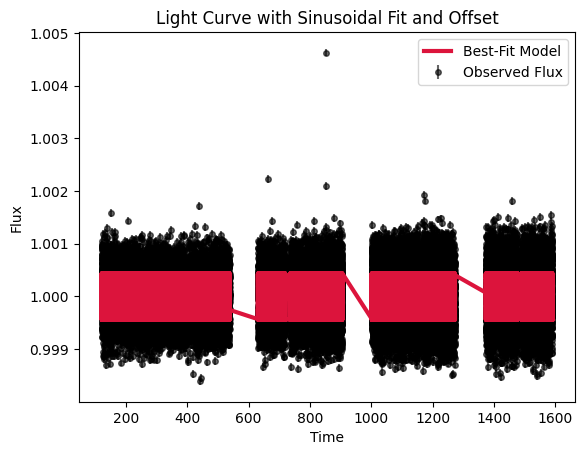

In [12]:
weight_fit = 1 / sigma_fit**2

def weighted_least_squares(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return A @ np.linalg.solve(ATA, ATb)

y_hat = weighted_least_squares(A_integral, flux_fit, weight_fit)
     


# Plot observed flux (data)
plt.errorbar(
    t_fit, flux_fit, yerr=sigma_fit, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)

# Plot best-fit model (bold and on top)
plt.plot(
    t_fit, y_hat, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Light Curve with Sinusoidal Fit and Offset')
plt.legend()
plt.show()
     

     
##why isn't the error bar as great?

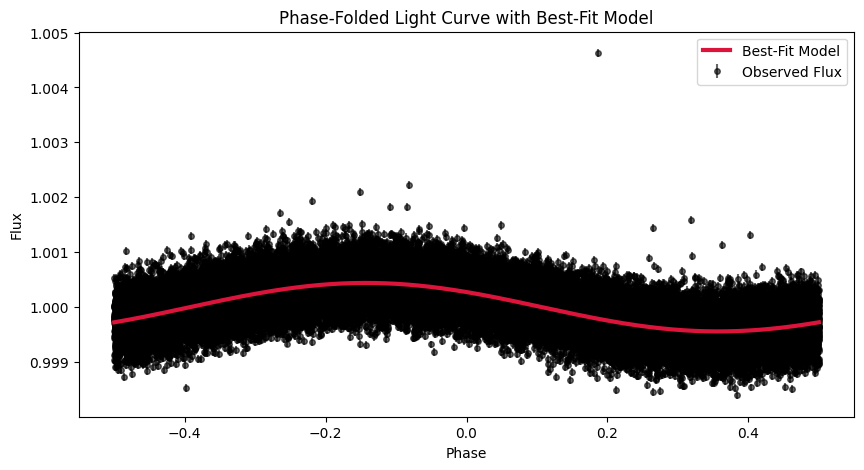

In [13]:
# Compute period from selected frequency
P = 1 / refined_freq[0]

# Reference time
t0 = t_fit[np.argmin(flux)] #this should center the phase around zero?

# phase folding over the select period
phase = ((t_fit - t0) % P) / P
phase[phase > 0.5] -= 1 # shifting range


# Sort for better plotting // i think data may already be sorted
sorted_indices = np.argsort(phase)
phase_sorted = phase[sorted_indices]
flux_sorted = flux_fit[sorted_indices]
sigma_sorted = sigma_fit[sorted_indices]
model_sorted = y_hat[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(
    phase_sorted, flux_sorted, yerr=sigma_sorted, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)
plt.plot(
    phase_sorted, model_sorted, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Phase-Folded Light Curve with Best-Fit Model')
plt.legend()
plt.show()

In [14]:
def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  # Adjusted range around nu
chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])

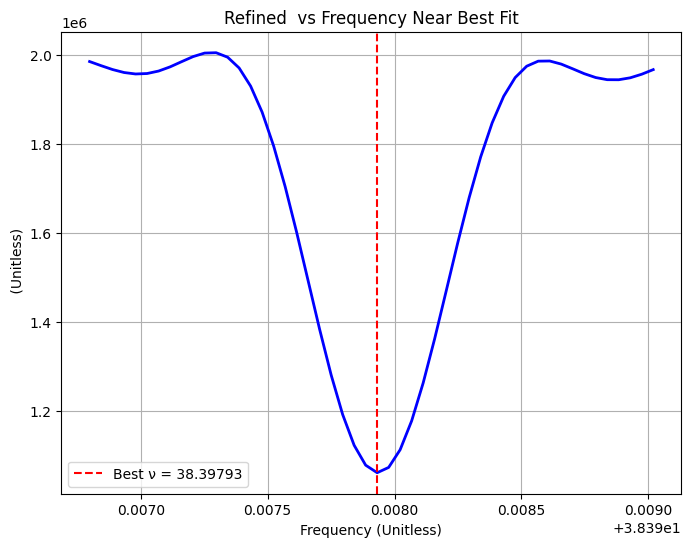

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(fine_freqs, chi2_fine, 'b-', lw=2, label=r"")
plt.axvline(nu, color='red', linestyle='--', label=f'Best ν = {nu:.5f}')

plt.xlabel("Frequency (Unitless)")
plt.ylabel(r" (Unitless)")
plt.title(r"Refined  vs Frequency Near Best Fit")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#My original get_started function finds maxs, I'm trying to find mins

def get_mins(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the lowest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of lowest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the lowest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(-ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

In [17]:
min_index = get_mins(1, fine_freqs, chi2_fine)
print(min_index)

[4]


In [18]:
refined_nu, refined_nu_power, second_derivative_nu = refine_peaks(fine_freqs, chi2_fine, min_index)

In [19]:
print(refined_nu, refined_nu_power)

[38.39699136] [1956307.5]


In [20]:
print(nu) ###yay it's refined

38.39793161036696


In [21]:
def find_min_and_refine(xs,ys):
    indxs, properties = find_peaks(-ys)
    min_index =  indxs[np.argsort(-ys[indxs])[:1]]
    refined_x, refined_y, second_derivative = refine_peaks(xs, ys, min_index)
    return refined_x, refined_y

In [22]:
refined_nu, refined_nu_power = find_min_and_refine(fine_freqs, chi2_fine) 
print(refined_nu, refined_nu_power)

[38.39699136] [1956307.5]


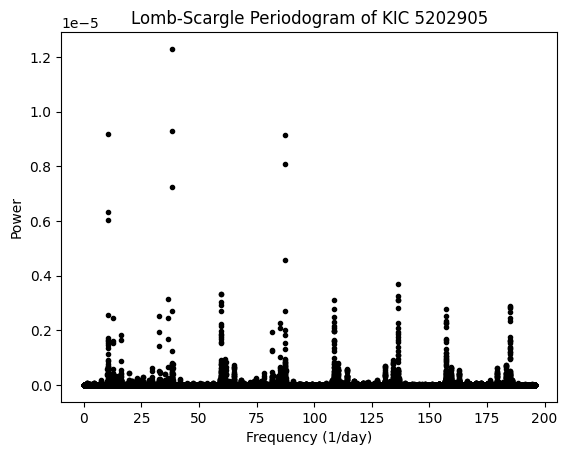

In [23]:
plt.plot(freq, power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
#plt.axvline(nu_vals[I][0])
plt.show() 

##Top 20 peaks

indices = get_started(20, freq, power)


In [24]:
##The nu frequency used here is unrefined
num_of_mins = 20

indices = get_started(num_of_mins,freq,power)
nu_vals = []
best_freqs = []
best_chi2s = []

for index in indices:
    nu = freq[index]
    fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  
    chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])
    best_freq, best_chi2 = find_min_and_refine(fine_freqs,chi2_fine)
    nu_vals.append(nu)
    best_freqs.append(best_freq.item())
    best_chi2s.append(best_chi2.item())

nu_vals = np.array(nu_vals)
best_freqs = np.array(best_freqs)
best_chi2s = np.array(best_chi2s)


arrays = np.vstack((nu_vals,best_freqs,best_chi2s))

print(arrays)



[[3.83979027e+01 1.05411297e+01 8.73369351e+01 1.36276194e+02
  5.94801620e+01 5.94826556e+01 3.63720091e+01 1.36273247e+02
  1.08424408e+02 1.36278688e+02 5.94774418e+01 1.85220214e+02
  1.85212280e+02 1.08416474e+02 1.57366161e+02 1.05436232e+01
  3.27661136e+01 1.57350066e+02 1.08413754e+02 1.85209559e+02]
 [3.83969914e+01 1.05403076e+01 8.73360629e+01 1.36277007e+02
  5.94811314e+01 5.94836391e+01 3.63729808e+01 1.36272373e+02
  1.08425404e+02 1.36279503e+02 5.94765270e+01 1.85221245e+02
  1.85211523e+02 1.08417424e+02 1.57367100e+02 1.05444583e+01
  3.27651395e+01 1.57350879e+02 1.08412766e+02 1.85208678e+02]
 [1.95627925e+06 1.97597204e+06 1.99282750e+06 1.96173400e+06
  1.96474000e+06 1.98755475e+06 1.98868194e+06 1.99837050e+06
  1.99332250e+06 1.98534300e+06 1.99353912e+06 1.98690000e+06
  2.00433850e+06 1.97336300e+06 2.00056850e+06 1.99863994e+06
  1.99368106e+06 2.00411400e+06 2.00095275e+06 1.99921650e+06]]


In [25]:
#Using peak refining code first

refined_peaks = refine_peaks(freq, power, indices)[0]

print(refined_peaks)


[ 38.39793161  10.54113514  87.33700543 136.27612239  59.48022385
  59.48271053  36.37205006 136.27327446 108.42442646 136.27860647
  59.47742049 185.22029981 185.2123883  108.41650755 157.36611748
  10.54362997  32.76608044 157.3499781  108.41369639 185.20955597]


In [26]:
#finding chi-squared minimum with refined frequency

nu_vals = []
best_freqs = []
best_chi2s = []

for peak in refined_peaks:
    nu = peak
    fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  
    chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])
    best_freq, best_chi2 = find_min_and_refine(fine_freqs,chi2_fine)
    nu_vals.append(nu)
    best_freqs.append(best_freq.item())
    best_chi2s.append(best_chi2.item())

nu_vals = np.array(nu_vals)
best_freqs = np.array(best_freqs)
best_chi2s = np.array(best_chi2s)

In [27]:
I = np.argsort(best_chi2s)
for f1, f2, chi2 in zip(nu_vals[I], best_freqs[I], best_chi2s[I]):
    print(f1, f2, chi2, chi2-np.min(best_chi2s))

38.39793161036696 38.39699136389046 1956307.5 0.0
136.27612239376816 136.27700626510733 1961736.0 5428.5
59.48022384829169 59.481131635646854 1964736.5 8429.0
108.41650754557553 108.41742414526988 1973359.0 17051.5
10.541135137914107 10.540306674479343 1975987.41015625 19679.91015625
136.27860647063906 136.27950317373717 1985346.0 29038.5
185.22029981069358 185.22124476791998 1986900.0 30592.5
59.48271052948597 59.48363877181163 1987547.75 31240.25
36.372050060822616 36.37298085346954 1988696.5625 32389.0625
87.3370054332177 87.3360625159125 1992841.5 36534.0
108.42442646440558 108.42540343668485 1993330.5 37023.0
59.47742049035192 59.476526819526576 1993544.5 37237.0
32.766080443759265 32.76513896460471 1993687.53125 37380.03125
136.2732744609631 136.27237274073863 1998378.0 42070.5
10.543629965064254 10.544457333443486 1998636.9150390625 42329.4150390625
185.20955596799607 185.20867784497662 1999214.0 42906.5
157.36611747624835 157.36709974525283 2000568.5 44261.0
108.41369638828873 

In [28]:
def fit_and_subtract(om, ts, fs, ws, T):
    X = integral_design_matrix(ts, om, T)
    return fs - X @ np.linalg.solve(X.T @ (ws[:, None] * X), X.T @ (ws * fs))

In [29]:
flux_foo = fit_and_subtract(2. * np.pi * nu_vals[I][0], t_fit, flux_fit, weight_fit, lc_exptime)

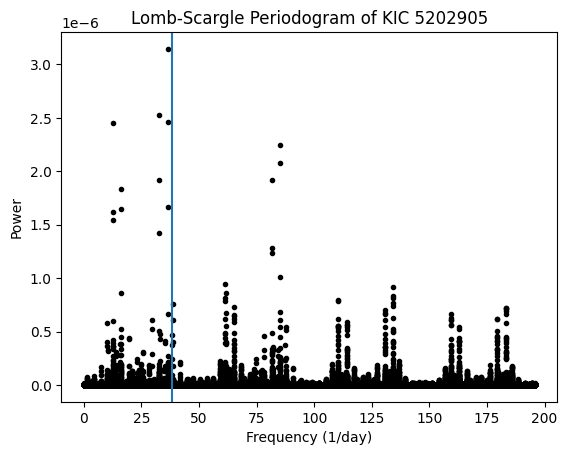

In [30]:
lc_foo = lc.copy()
lc_foo.flux = flux_foo

pg2 = lc_foo.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power2 = pg2.power.value
freq2 = pg2.frequency.to(1/u.day).value 

plt.plot(freq2, power2,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.axvline(nu_vals[I][0])
plt.show() 

In [31]:
indices2 = get_started(20, freq2, power2)
refined_peaks2 = refine_peaks(freq2, power2, indices2)[0]


In [32]:
#subtracting next best frequency

nu_vals2 = []
best_freqs2 = []
best_chi2s2 = []

for peak in refined_peaks2:
    nu = peak
    fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  
    chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])
    best_freq, best_chi2 = find_min_and_refine(fine_freqs,chi2_fine)
    nu_vals2.append(nu)
    best_freqs2.append(best_freq.item())
    best_chi2s2.append(best_chi2.item())

nu_vals2 = np.array(nu_vals2)
best_freqs2 = np.array(best_freqs2)
best_chi2s2 = np.array(best_chi2s2)

In [33]:
II = np.argsort(best_chi2s2)
for f1, f2, chi2 in zip(nu_vals[II], best_freqs2[II], best_chi2s2[II]):
    print(f1, f2, chi2, chi2-np.min(best_chi2s2))

38.39793161036696 36.37298077642868 1988697.0625 0.0
36.372050060822616 61.50699982846869 1990374.625 1677.5625
136.2732744609631 134.25111278345722 1991369.0 2671.9375
10.541135137914107 32.76513896445302 1993687.5 4990.4375
32.766080443759265 183.18739458290017 1994890.0 6192.9375
10.543629965064254 65.11299057552394 1995291.375 6594.3125
108.41369638828873 130.64514161004868 1995623.0 6925.9375
136.27612239376816 85.31024962681657 1998279.5 9582.4375
108.42442646440558 61.50950225958621 1999876.0625 11179.0
136.27860647063906 134.25362695589948 2000056.25 11359.1875
108.41650754557553 110.45125471469437 2000939.25 12242.1875
87.3370054332177 12.566105138234951 2001055.91796875 12358.85546875
157.3499780981043 183.19538284870998 2001118.5 12421.4375
185.20955596799607 130.64764563550364 2001814.75 13117.6875
185.22029981069358 134.24653230388626 2001920.75 13223.6875
59.48271052948597 16.172070782475554 2002602.21484375 13905.15234375
59.48022384829169 81.70422706589787 2002823.75 14

In [34]:
flux_foo2 = fit_and_subtract(2. * np.pi * nu_vals2[II][0], t_fit, flux_fit, weight_fit, lc_exptime)

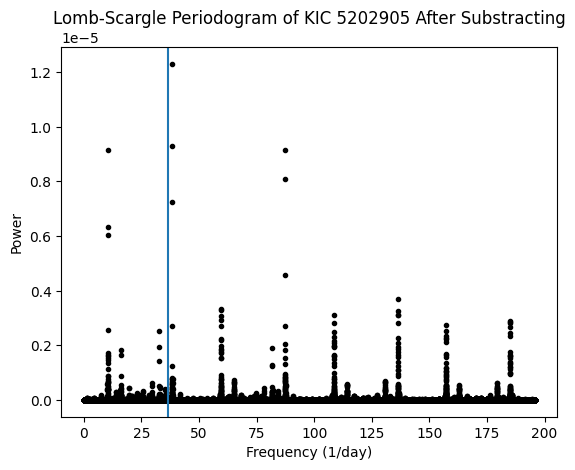

In [35]:
lc_foo2 = lc_foo.copy()
lc_foo2.flux = flux_foo2

pg3 = lc_foo2.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power3 = pg3.power.value
freq3 = pg3.frequency.to(1/u.day).value 

plt.plot(freq3, power3,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905 After Substracting")
plt.axvline(nu_vals2[II][0])
#plt.xlim(30, 42)
plt.show() 

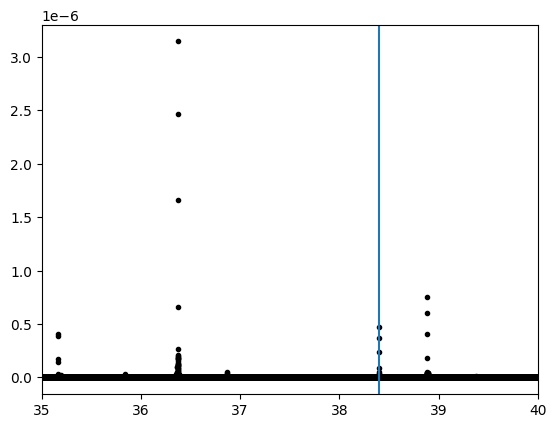

In [36]:
plt.plot(freq2, power2, 'k.')
plt.axvline(nu_vals[I][0])
plt.xlim(35,40)
plt.show()

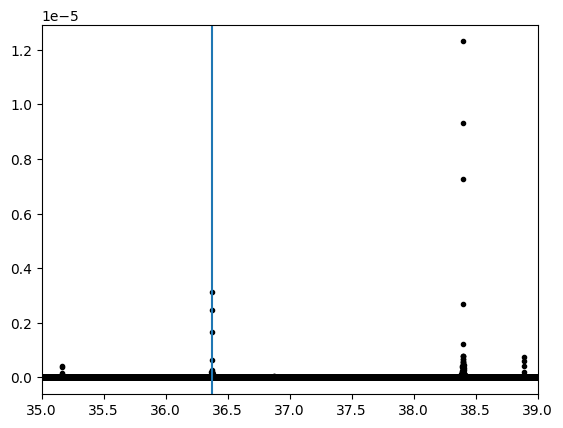

36.37205125354241


In [37]:
plt.plot(freq, power, 'k.')
plt.xlim(35,39)
plt.axvline(nu_vals2[II][0])
plt.show()
print(nu_vals2[II][0])

In [38]:
freq[indices]

array([ 38.39790269,  10.54112967,  87.33693506, 136.27619411,
        59.48016204,  59.48265559,  36.37200915, 136.27324719,
       108.42440819, 136.27868766,  59.47744181, 185.22021357,
       185.21227956, 108.41647417, 157.36616079,  10.54362322,
        32.76611358, 157.35006608, 108.41375394, 185.20955933])

In [39]:
##defining another integral_chi_sqaured
def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    pars, invar = weighted_least_squares(A, ys, ws)
    return np.sum(ws * (ys - A @ pars)**2)

# Step 1: Define fine frequency grid around best_nu (extended range)
fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  # Adjusted range around nu
chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])

ValueError: too many values to unpack (expected 2)